In [19]:
import sys
sys.path.append('../')

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from scipy.integrate import solve_ivp
from scipy.signal import savgol_filter
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from typing import Optional

from src.batch_pinn import PINN, numpy_to_tensor, train
from src.utils import get_data

pd.options.mode.chained_assignment = None

np.set_printoptions(precision=4)

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [34]:
def plot_simulation(full_df: pd.DataFrame, t: Optional[list] = None, y: Optional[list] = None, train_df: Optional[pd.DataFrame] = None, net_df: Optional[pd.DataFrame] = None):
    plt.figure(figsize=(10, 5))
    plt.scatter(full_df['RTime'], full_df['Glucose'], label='Glucose (All)', color='red', alpha=0.2)   
    plt.scatter(full_df['RTime'], full_df['Biomass'], label='Biomass (All)', color='green', alpha=0.2)
    if t is not None:
        plt.plot(t, y[0], label='Biomass (ODE)', alpha=0.3)
        plt.plot(t, y[1], label='Glucose (ODE)', alpha=0.3)
    if train_df is not None:
        plt.scatter(train_df['RTime'], train_df['Glucose'], label='Glucose (Train)', color='red', alpha=1)   
        plt.scatter(train_df['RTime'], train_df['Biomass'], label='Biomass (Train)', color='green', alpha=1)
    if net_df is not None:
        plt.scatter(net_df['RTime'], net_df['Glucose'], marker='+', label='Glucose (Predicted)', color='red', s=100, alpha=0.5)
        plt.scatter(net_df['RTime'], net_df['Biomass'], marker='+', label='Biomass (Predicted)', color='green', s=100, alpha=0.5)
    plt.legend()
    plt.show()
    
def simulate(df, mu_max, Ks, Yxs):
    mu_max = mu_max
    Ks = Ks
    Yxs = Yxs
    
    def system_ode(t, y):
        X, S = y
        mu = mu_max * S / (Ks + S)
        dXdt = mu * X
        dSdt = - mu * X / Yxs
        return [dXdt, dSdt]
    
    t_eval = np.linspace(df['RTime'].min(), df['RTime'].max(), 10000)
    sol = solve_ivp(system_ode, [df['RTime'].min(), df['RTime'].max()], \
        [df['Biomass'].iloc[0], df['Glucose'].iloc[0]], t_eval=t_eval)
    return sol

__Parameter estimation using PINN__

In [35]:
FILENAME = '../data/data_processed.xlsx'
EXPERIMENT = 'BR01'

data = get_data(file_name=FILENAME)

df = data.loc[EXPERIMENT]

# Keep only the Batch phase
df = df[df['Process']=='B']
print(f'Dataset shape: {df.shape}')

Dataset shape: (8, 8)


In [44]:
# # Fit a polynomial to the data
# poly = PolynomialFeatures(degree=2)
# X = poly.fit_transform(df['RTime'].values.reshape(-1, 1))
# poly_reg = LinearRegression().fit(X, df[['Biomass', 'Glucose']])
# poly_df = pd.DataFrame({'RTime': df['RTime'], 'Biomass': poly_reg.predict(X)[:, 0], 'Glucose': poly_reg.predict(X)[:, 1]})

# plot_simulation(full_df=df, net_df=poly_df)


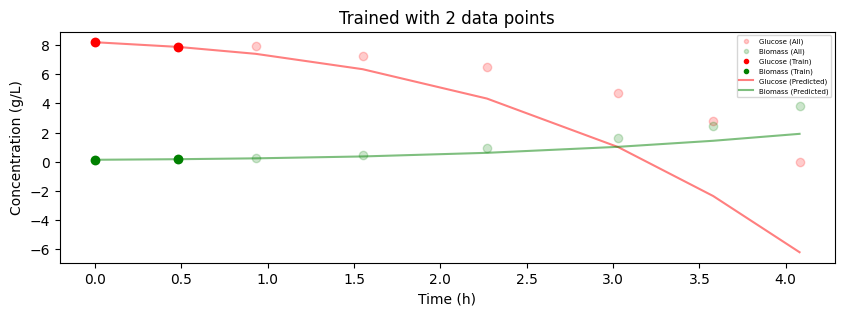

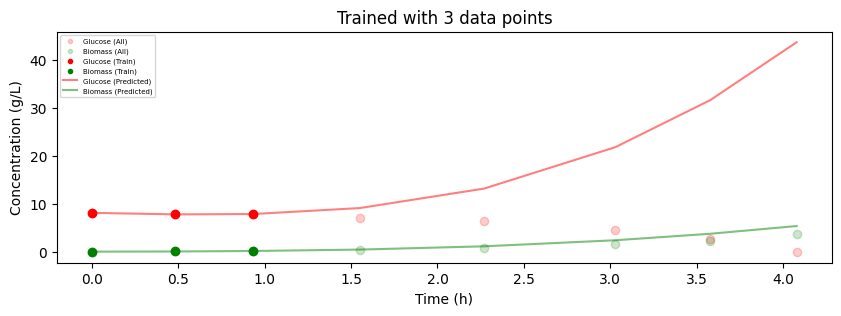

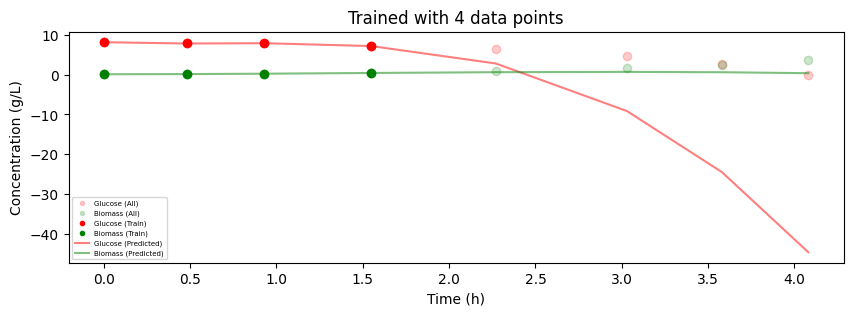

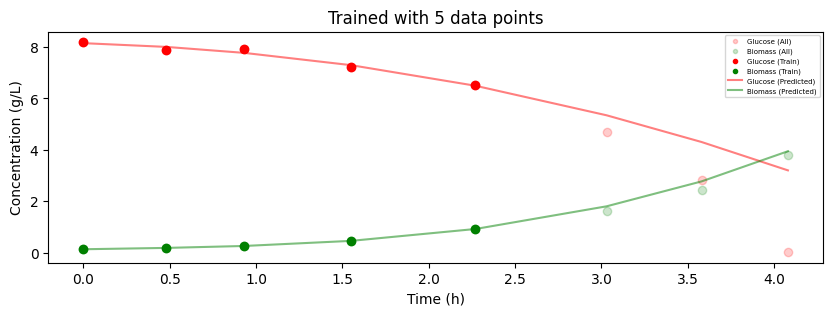

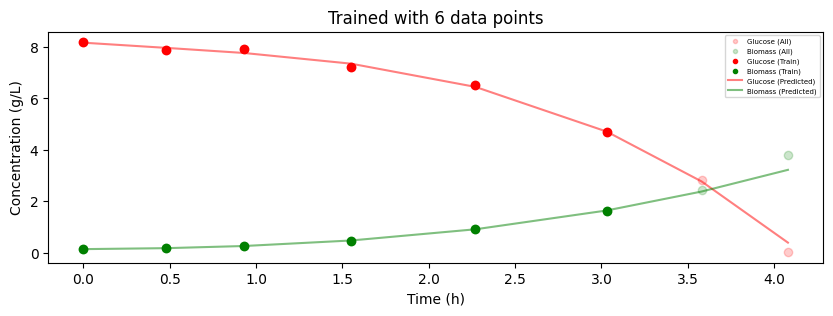

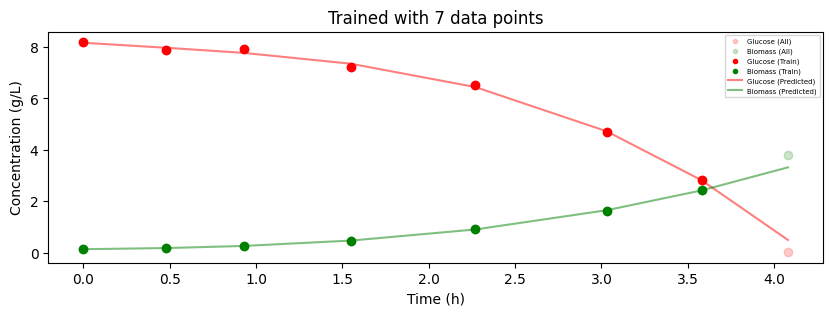

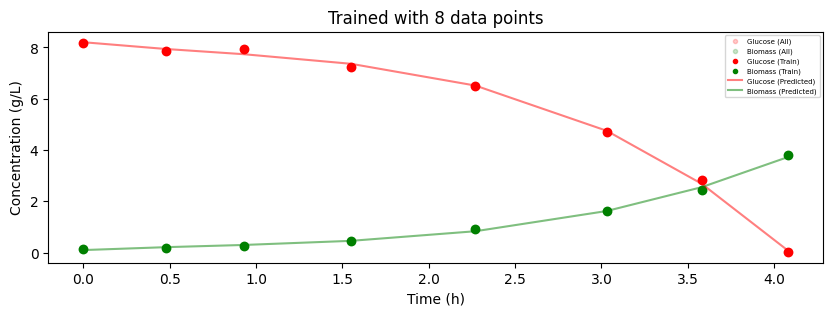

In [62]:
def plot_linear_model(train_df: pd.DataFrame, full_df: pd.DataFrame, pred_df: pd.DataFrame):
    plt.figure(figsize=(10, 3))
    plt.scatter(full_df['RTime'], full_df['Glucose'], label='Glucose (All)', color='red', alpha=0.2)
    plt.scatter(full_df['RTime'], full_df['Biomass'], label='Biomass (All)', color='green', alpha=0.2)
    plt.scatter(train_df['RTime'], train_df['Glucose'], label='Glucose (Train)', color='red', alpha=1)
    plt.scatter(train_df['RTime'], train_df['Biomass'], label='Biomass (Train)', color='green', alpha=1)
    plt.plot(pred_df['RTime'], pred_df['Glucose'], label='Glucose (Predicted)', color='red', alpha=0.5)
    plt.plot(pred_df['RTime'], pred_df['Biomass'], label='Biomass (Predicted)', color='green', alpha=0.5)
    plt.legend(fontsize=5, markerscale=0.5)
    plt.xlabel('Time (h)')
    plt.ylabel('Concentration (g/L)')
    plt.title(f'Trained with {len(train_df)} data points')
    plt.show()

def fit_poly(train_df: pd.DataFrame, full_df: pd.DataFrame, degree: int = 3):
    poly = PolynomialFeatures(degree=degree)
    X = poly.fit_transform(train_df['RTime'].values.reshape(-1, 1))
    poly_reg = LinearRegression().fit(X, train_df[['Biomass', 'Glucose']])
    poly_df = pd.DataFrame({'RTime': full_df['RTime'], 'Biomass': poly_reg.predict(poly.fit_transform(full_df['RTime'].values.reshape(-1, 1)))[:, 0], \
        'Glucose': poly_reg.predict(poly.fit_transform(full_df['RTime'].values.reshape(-1, 1)))[:, 1]})
    return poly_df
    

def fit_linear(train_df: pd.DataFrame, full_df: pd.DataFrame):
    # Linear model
    lin_reg = LinearRegression().fit(train_df[['RTime']], train_df[['Biomass', 'Glucose']])
    lin_df = pd.DataFrame({'RTime': full_df['RTime'], 'Biomass': lin_reg.predict(full_df[['RTime']])[:, 0], 'Glucose': lin_reg.predict(full_df[['RTime']])[:, 1]})
    return lin_df

for i in range(2, len(df)+1):
    train_df = df.iloc[:i]
    # pred_df = fit_linear(train_df, df)
    pred_df = fit_poly(train_df, df, degree=3)
    plot_linear_model(train_df, df, pred_df) 
    
    

In [9]:
for i in range(2, len(df)+1):
    print(f'Training using {i} data points')
    
    _df = df.iloc[:i]
    t_start, t_end = _df['RTime'].min(), _df['RTime'].max()
    
    t = numpy_to_tensor(_df['RTime'].values)
    X = numpy_to_tensor(_df['Biomass'].values)
    S = numpy_to_tensor(_df['Glucose'].values)
    X_S = torch.cat((X, S), 1)
    
    # Define and Train PINN 
    net = PINN(1, 2, t_start=t_start, t_end=t_end)     
    net, total_loss, loss_data, loss_ic, loss_ode = train(net, t, X_S, df, num_epochs=2000, verbose=False)

    # Store the results
    net_df = pd.DataFrame(columns=['RTime', 'Biomass', 'Glucose'])
    t_test = df['RTime'].values
    net_df['RTime'] = t_test
    t_test = numpy_to_tensor(t_test)
    net_df['Biomass'] = net.forward(t_test).detach().cpu().numpy()[:, 0]
    net_df['Glucose'] = net.forward(t_test).detach().cpu().numpy()[:, 1]
    
    mu_max = net.mu_max.item()
    Ks = net.K_s.item()
    Yxs = net.Y_xs.item()
    
    print(f'mu_max: {mu_max:4f}, Ks: {Ks:4f}, Yxs: {Yxs:.4f}')
    
    solution = simulate(df, mu_max, Ks, Yxs)
    plot_simulation(solution.t, solution.y, df, _df, net_df)